In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import torch, torch_geometric
import wandb
import utils
from IPython.display import clear_output
import json
import math
from torch_geometric.datasets import TUDataset

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import itertools

/opt/homebrew/Caskroom/miniconda/base/envs/pyg-m1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [130]:
def get_framework(x):
    if isinstance(x, str) and x.startswith("1WL+NN:GIN"): return "1-WL+NN:GNN"
    elif isinstance(x, str) and x.startswith("1WL+NN:GCN"): return "1-WL+NN:GNN"
    elif isinstance(x, str) and x.startswith("1WL+NN:GAT"): return "1-WL+NN:GNN"
    elif isinstance(x, str) and x.startswith("1WL+NN"): return "1-WL+NN"
    elif isinstance(x, str) and x.startswith("GAT"): return "GNN"
    elif isinstance(x, str) and x.startswith("GIN"): return "GNN"
    elif isinstance(x, str) and x.startswith("GCN"): return "GNN"
    
    else: return pd.NA

def get_model_type(x):
    if isinstance(x, str) and x.startswith("1WL+NN:GIN"): return "1-WL+NN:GIN"
    elif isinstance(x, str) and x.startswith("1WL+NN:GCN"): return "1-WL+NN:GCN"
    elif isinstance(x, str) and x.startswith("1WL+NN:GAT"): return "1-WL+NN:GAT"
    elif isinstance(x, str) and x.startswith("1WL+NN"): return "1-WL+NN"
    elif isinstance(x, str) and x.startswith("GAT"): return "GAT"
    elif isinstance(x, str) and x.startswith("GIN"): return "GIN"
    elif isinstance(x, str) and x.startswith("GCN"): return "GCN"
    
    else: return pd.NA

def get_pool_type(x):
    if isinstance(x, str) and x.endswith("Embedding-Sum"): return "Embedding:Sum"
    elif isinstance(x, str) and x.endswith("Embedding-Max"): return "Embedding:Max"
    elif isinstance(x, str) and x.endswith("Embedding-Mean"): return "Embedding:Mean"
    elif isinstance(x, str) and x.endswith("Mean"): return "Mean"
    elif isinstance(x, str) and x.endswith("Sum"): return "Sum"
    elif isinstance(x, str) and x.endswith("Max"): return "Max"
    elif isinstance(x, str) and x.endswith("Set2Set"): return "Set2Set"
    else: return pd.NA

api = wandb.Api(timeout=30)

# Project is specified by <entity/project-name>
runs = api.runs("eric-bill/BachelorThesisExperiments")

dist_data = []
for run in runs:
    if run.state == "finished":
        dist_data.append(run.summary._json_dict | run.config | {'config' : str(run._attrs['config'])} |
                    {'Tags' : run.tags[0] if len(run.tags) == 1 else run.tags} | {'name' : run.name, 'run_id' : run.id})
        
        # if 'model' in run.config:
        #     run.config['pool_type'] = get_pool_type(run.config['model'])
        #     run.config['model_type'] = get_model_type(run.config['model'])
        #     run.update()
        
runs_df = pd.DataFrame(dist_data)
runs_df['model_type'] = runs_df['model'].apply(get_model_type)
runs_df['pool_type'] = runs_df['model'].apply(get_pool_type)
runs_df['framework'] = runs_df['model'].apply(get_framework)
runs_df['dataset_type'] = runs_df['dataset'].apply(lambda x: 'Regression' if x in ['Alchemy10K', 'Zinc 10k', 'Zinc', 'Alchemy'] else 'Classification')
runs_df.to_csv("project.csv")

In [138]:
runs_df.columns

Index(['train_accuracy_std', '_wandb', 'num_epochs', 'val_accuracy',
       'test_accuracy', 'train_accuracy', 'test_accuracy_std', '_step',
       '_runtime', '_timestamp', 'num_epochs_std', 'val_accuracy_std', 'jk',
       'lr', 'act', 'k_wl', 'norm', 'seed', 'tags', 'model', 'device',
       'k_fold', 'dataset', 'dropout', 'act_first', 'pool_type', 'batch_size',
       'gnn_kwargs', 'max_epochs', 'mlp_kwargs', 'model_type', 'num_layers',
       'use_one_hot', 'num_repition', 'wl_convergence', 'hidden_channels',
       'config', 'Tags', 'name', 'run_id', 'knn_accuracies_std',
       'svm_lin_accuracies_std', 'svm_rbf_accuracies_std',
       'svm_rbf_accuracies', 'k', 'knn_accuracies', 'svm_lin_accuracies',
       'embedding_dim', 'encoding_kwargs', 'test_error_std',
       'test_error_log_std', 'test_error', 'test_error_log', 'convergence',
       'max_acc', 'wl_max_iterations', 'tsne', 'max_accuracy', 'knn', 'pca',
       'transformer_kwargs', 'Shannon Diversity', '1-WL Accuracy',
 

In [146]:
runs_df['dataset'].unique()

array(['NCI1', 'ENZYMES', 'MUTAG', 'IMDB-BINARY', 'PROTEINS',
       'REDDIT-BINARY', 'Alchemy10K', 'Zinc 10k', 'Zinc', 'Alchemy',
       'FRANKENSTEIN', 'Peking_1', 'KKI', 'AIDS', 'OHSU', 'DHFR', 'BZR',
       'COX2', 'NCI109', 'PTC_MR', 'DD', 'COLLAB', 'IMDB-MULTI', nan],
      dtype=object)

In [160]:
runs_df[(runs_df['framework'] == 'GNN') & (runs_df['dataset'] == 'Zinc')]['pool_type'].unique()

array(['Max', 'Mean', 'Sum'], dtype=object)

In [23]:
print(f'Total computation time: {round(runs_df["_runtime"].sum() / (60 * 60), 2)} hours with {len(runs_df)} runs.')

Total computation time: 2114.92 hours with 6754 runs.


In [5]:
def get_acc_and_std(dataset, group_col, acc_col='test_accuracy', std_col='test_accuracy_std', latex=False, reg=False):
    data = []

    for (grouping_name, grouping_df) in dataset.groupby(group_col):

        if reg:
            best_idx = grouping_df[acc_col].idxmin()

            if math.isnan(best_idx):
                continue

            loss = grouping_df.loc[best_idx, acc_col]
            std = grouping_df.loc[best_idx, std_col]

            log_loss = grouping_df.loc[best_idx, 'test_error_log']
            log_std = grouping_df.loc[best_idx, 'test_error_log_std']

            if latex:
                result = f'{loss:.3f} {{\scriptsize $\pm {std:.3f}$}} {log_loss:.3f} {{\scriptsize $\pm {log_std:.3f}$}} & '
            else:
                result = f"{loss:.3f} \u00B1 {std:.3f}"

        else:
            best_idx = grouping_df[acc_col].idxmax()
        
            if math.isnan(best_idx):
                continue
        
            acc = grouping_df.loc[best_idx, acc_col]
            std = grouping_df.loc[best_idx, std_col]
            if latex:
                result = f'{acc:.1f} \scriptsize $\pm {std:.1f}$'
            else:
                result = f"{acc:.3f} \u00B1 {std:.3f}"

        data.append({group_col[i] : grouping_name[i] for i in range(len(group_col))} |
                    {acc_col : result, 'run_id' : grouping_df.loc[best_idx, 'run_id']})
    
    return pd.DataFrame(data)

In [26]:
runs_df.pivot_table(index=['model_type'], 
                    columns=['dataset_type'], values=['test_accuracy'], 
                    aggfunc=lambda x: len(x)).fillna(0).astype(int)

test_accuracy           
dataset_type Classification Regression
model_type                            
1-WL+NN                4867        555
1-WL+NN:GAT              85          0
1-WL+NN:GCN              88          0
1-WL+NN:GIN              91          0
GAT                     314          0
GCN                     364          0
GIN                     349         16

In [28]:


latex_table = get_acc_and_std(runs_df, group_col=['dataset_type', 'model_type', 'pool_type', 'dataset'], acc_col='test_accuracy', std_col='test_accuracy_std', latex=True)
latex_table = latex_table.pivot_table(index=['model_type', 'pool_type'], 
                                      columns=['dataset_type', 'dataset'], values=['test_accuracy'], aggfunc=lambda x: x)
latex_table

test_accuracy  \
dataset_type                            Classification   
dataset                                        ENZYMES   
model_type  pool_type                                    
1-WL+NN     Embedding:Max   41.9 \scriptsize $\pm 7.5$   
            Embedding:Mean  45.8 \scriptsize $\pm 6.8$   
            Embedding:Sum   48.3 \scriptsize $\pm 8.1$   
            Max             16.7 \scriptsize $\pm 4.2$   
            Mean            18.2 \scriptsize $\pm 4.8$   
            Sum             18.0 \scriptsize $\pm 6.2$   
1-WL+NN:GAT Max             17.9 \scriptsize $\pm 5.9$   
            Mean            32.5 \scriptsize $\pm 6.9$   
            Sum             35.9 \scriptsize $\pm 6.9$   
1-WL+NN:GCN Max             17.8 \scriptsize $\pm 4.9$   
            Mean            23.2 \scriptsize $\pm 5.8$   
            Sum             33.7 \scriptsize $\pm 6.7$   
1-WL+NN:GIN Max             21.5 \scriptsize $\pm 6.8$   
            Mean            18.7 \scriptsize $\pm 4.7$   
            Sum             22.3 \scriptsize $\pm 5.4$   
GAT         Max             31.2 \scriptsize $\pm 6.0$   
            Mean            28.9 \scriptsize $\pm 5.9$   
            Sum             34.4 \scriptsize $\pm 7.0$   
GCN         Max             33.1 \scriptsize $\pm 7.5$   
            Mean            29.9 \scriptsize $\pm 5.7$   
            Sum             31.7 \scriptsize $\pm 7.2$   
GIN         Max             29.2 \scriptsize $\pm 6.2$   
            Mean            31.7 \scriptsize $\pm 6.7$   
            Sum             28.9 \scriptsize $\pm 8.7$   

                                                        \
dataset_type                                             
dataset                                    IMDB-BINARY   
model_type  pool_type                                    
1-WL+NN     Embedding:Max   69.4 \scriptsize $\pm 4.9$   
            Embedding:Mean  72.4 \scriptsize $\pm 4.1$   
            Embedding:Sum   72.0 \scriptsize $\pm 3.8$   
            Max             52.0 \scriptsize $\pm 5.3$   
            Mean            59.4 \scriptsize $\pm 5.8$   
            Sum             57.5 \scriptsize $\pm 5.1$   
1-WL+NN:GAT Max             69.6 \scriptsize $\pm 5.0$   
            Mean            65.4 \scriptsize $\pm 5.5$   
            Sum             70.6 \scriptsize $\pm 5.5$   
1-WL+NN:GCN Max             71.1 \scriptsize $\pm 5.1$   
            Mean            72.0 \scriptsize $\pm 4.1$   
            Sum             70.6 \scriptsize $\pm 5.0$   
1-WL+NN:GIN Max             69.8 \scriptsize $\pm 5.6$   
            Mean            70.3 \scriptsize $\pm 5.1$   
            Sum             67.7 \scriptsize $\pm 6.5$   
GAT         Max             70.7 \scriptsize $\pm 4.8$   
            Mean            70.9 \scriptsize $\pm 3.7$   
            Sum             72.2 \scriptsize $\pm 4.5$   
GCN         Max             73.5 \scriptsize $\pm 4.1$   
            Mean            74.7 \scriptsize $\pm 3.8$   
            Sum             73.0 \scriptsize $\pm 4.4$   
GIN         Max             70.8 \scriptsize $\pm 4.7$   
            Mean            71.1 \scriptsize $\pm 5.4$   
            Sum             69.5 \scriptsize $\pm 4.8$   

                                                         \
dataset_type                                              
dataset                                           MUTAG   
model_type  pool_type                                     
1-WL+NN     Embedding:Max   81.1 \scriptsize $\pm 11.2$   
            Embedding:Mean   84.1 \scriptsize $\pm 9.1$   
            Embedding:Sum    85.1 \scriptsize $\pm 8.6$   
            Max             73.8 \scriptsize $\pm 12.4$   
            Mean            77.1 \scriptsize $\pm 11.5$   
            Sum             66.8 \scriptsize $\pm 13.9$   
1-WL+NN:GAT Max             78.2 \scriptsize $\pm 11.4$   
            Mean            77.8 \scriptsize $\pm 10.4$   
            Sum             83.9 \scriptsize $\pm 11.0$   
1-WL+NN:GCN Max         

In [8]:
latex_table = get_acc_and_std(runs_df, group_col=['framework', 'dataset'], acc_col='test_accuracy', std_col='test_accuracy_std', latex=False)
latex_table = latex_table.pivot_table(index=['framework'], 
                                      columns='dataset', values=['run_id'], aggfunc=lambda x: x)
latex_table

run_id                                                        
dataset       ENZYMES IMDB-BINARY     MUTAG      NCI1  PROTEINS REDDIT-BINARY
model_type                                                                   
1-WL+NN      fa4e4536    hsoebyq6  p7ijxb49  yhuvjjrt  loy2l5ey      okru4nbr
1-WL+NN:GNN  gatrs6mu    joovfyw4  ia4lzrjc  22znil9d  o9lxotms      e8www60v
GAT          ca9hfi7v    iw20mt4a  ddknmj9w  x5abxtfs  ei9whe4d      h42wxyfj
GCN          hhc3yspq    r06n1885  zvmd0p16  3x9owncw  4bkmzbdv      mckk4pv4
GIN          a2syk120    acrjsmmp  kxo6lydc  ircwl3vt  nor2tequ      dh88uxr7

In [30]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'pool_type', 'dataset'],
                               acc_col='test_error', std_col='test_error_std', latex=True, reg=True)
latex_table = latex_table.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['test_error'], aggfunc=lambda x: x)
latex_table

test_error  \
dataset                                                                                Alchemy   
model_type pool_type                                                                             
1-WL+NN    Embedding:Max   0.648 {\scriptsize $\pm 0.003$} -0.511 {\scriptsize $\pm 0.009$} &    
           Embedding:Mean  0.617 {\scriptsize $\pm 0.003$} -0.564 {\scriptsize $\pm 0.005$} &    
           Embedding:Sum   0.600 {\scriptsize $\pm 0.004$} -0.625 {\scriptsize $\pm 0.032$} &    
GIN        Max             0.604 {\scriptsize $\pm 0.004$} -0.578 {\scriptsize $\pm 0.009$} &    
           Mean            0.643 {\scriptsize $\pm 0.014$} -0.505 {\scriptsize $\pm 0.021$} &    
           Sum             0.523 {\scriptsize $\pm 0.016$} -0.705 {\scriptsize $\pm 0.035$} &    

                                                                                                \
dataset                                                                             Alchemy10K   
model_type pool_type                                                                             
1-WL+NN    Embedding:Max   0.409 {\scriptsize $\pm 0.003$} -1.023 {\scriptsize $\pm 0.009$} &    
           Embedding:Mean  0.355 {\scriptsize $\pm 0.004$} -1.269 {\scriptsize $\pm 0.020$} &    
           Embedding:Sum   0.305 {\scriptsize $\pm 0.001$} -1.740 {\scriptsize $\pm 0.042$} &    
GIN        Max             0.353 {\scriptsize $\pm 0.003$} -1.228 {\scriptsize $\pm 0.006$} &    
           Mean            0.314 {\scriptsize $\pm 0.004$} -1.467 {\scriptsize $\pm 0.033$} &    
           Sum             0.282 {\scriptsize $\pm 0.002$} -1.890 {\scriptsize $\pm 0.031$} &    

                                                                                                \
dataset                                                                                   Zinc   
model_type pool_type                                                                             
1-WL+NN    Embedding:Max   0.382 {\scriptsize $\pm 0.005$} -0.963 {\scriptsize $\pm 0.014$} &    
           Embedding:Mean  0.229 {\scriptsize $\pm 0.003$} -1.476 {\scriptsize $\pm 0.012$} &    
           Embedding:Sum   0.326 {\scriptsize $\pm 0.014$} -1.122 {\scriptsize $\pm 0.043$} &    
GIN        Max             0.124 {\scriptsize $\pm 0.004$} -2.089 {\scriptsize $\pm 0.034$} &    
           Mean            0.110 {\scriptsize $\pm 0.003$} -2.207 {\scriptsize $\pm 0.028$} &    
           Sum             0.104 {\scriptsize $\pm 0.005$} -2.265 {\scriptsize $\pm 0.044$} &    

                                                                                                
dataset                                                                               Zinc 10k  
model_type pool_type                                                                            
1-WL+NN    Embedding:Max   0.659 {\scriptsize $\pm 0.007$} -0.417 {\scriptsize $\pm 0.011$} &   
           Embedding:Mean  0.484 {\scriptsize $\pm 0.009$} -0.726 {\scriptsize $\pm 0.019$} &   
           Embedding:Sum   0.465 {\scriptsize $\pm 0.009$} -0.765 {\scriptsize $\pm 0.020$} &   
GIN        Max             0.427 {\scriptsize $\pm 0.009$} -0.851 {\scriptsize $\pm 0.022$} &   
           Mean            0.339 {\scriptsize $\pm 0.032$} -1.087 {\scriptsize $\pm 0.090$} &   
           Sum             0.298 {\scriptsize $\pm 0.034$} -1.218 {\scriptsize $\pm 0.114$} &

In [10]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'dataset'], acc_col='test_accuracy', std_col='test_accuracy_std', latex=True)
latex_table = latex_table.pivot_table(index=['model_type'], 
                                      columns='dataset', values=['test_accuracy'], aggfunc=lambda x: x)
latex_table

test_accuracy                              \
dataset                         ENZYMES                 IMDB-BINARY   
model_type                                                            
1-WL+NN      48.3 \scriptsize $\pm 8.1$  72.4 \scriptsize $\pm 4.1$   
1-WL+NN:GNN  35.9 \scriptsize $\pm 6.9$  72.0 \scriptsize $\pm 4.1$   
GAT          34.4 \scriptsize $\pm 7.0$  72.2 \scriptsize $\pm 4.5$   
GCN          33.1 \scriptsize $\pm 7.5$  74.7 \scriptsize $\pm 3.8$   
GIN          31.7 \scriptsize $\pm 6.7$  71.1 \scriptsize $\pm 5.4$   

                                                                      \
dataset                            MUTAG                        NCI1   
model_type                                                             
1-WL+NN       85.1 \scriptsize $\pm 8.6$  83.6 \scriptsize $\pm 2.2$   
1-WL+NN:GNN  83.9 \scriptsize $\pm 11.0$  78.2 \scriptsize $\pm 2.4$   
GAT          82.1 \scriptsize $\pm 11.2$  69.8 \scriptsize $\pm 2.6$   
GCN          81.5 \scriptsize $\pm 10.3$  70.4 \scriptsize $\pm 2.1$   
GIN           84.6 \scriptsize $\pm 8.7$  79.9 \scriptsize $\pm 2.2$   

                                                                     
dataset                        PROTEINS               REDDIT-BINARY  
model_type                                                           
1-WL+NN      75.2 \scriptsize $\pm 3.9$  78.4 \scriptsize $\pm 2.7$  
1-WL+NN:GNN  74.5 \scriptsize $\pm 4.1$  84.3 \scriptsize $\pm 2.8$  
GAT          73.4 \scriptsize $\pm 3.9$  78.1 \scriptsize $\pm 4.2$  
GCN          73.9 \scriptsize $\pm 4.0$  86.9 \scriptsize $\pm 3.2$  
GIN          74.3 \scriptsize $\pm 5.1$  76.1 \scriptsize $\pm 3.6$

In [11]:
pd.set_option('display.max_colwidth', None)
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'dataset'], acc_col='test_error', std_col='test_error_std',
                               latex=False, reg=True)
latex_table = latex_table.pivot_table(index=['model_type'], 
                                      columns='dataset', values=['run_id'], aggfunc=lambda x: x)
latex_table

run_id                               
dataset      Alchemy Alchemy10K      Zinc  Zinc 10k
model_type                                         
1-WL+NN     yb2b0otd   zf33bc3a  ef9kymgb  67vla6nv
GIN         bvg6fdbc   lbqd1ugs  ixv8m9im  xmvds5vv

In [12]:
['yb2b0otd',	'zf33bc3a',	'ef9kymgb',	'67vla6nv']

['yb2b0otd', 'zf33bc3a', 'ef9kymgb', '67vla6nv']

In [13]:
runs_df[runs_df['run_id'].isin(['yb2b0otd',	'zf33bc3a',	'ef9kymgb',	'67vla6nv'])][['dataset', 'k_wl']]

,dataset,k_wl
1129,Zinc,3.0
1497,Alchemy,1.0
1574,Zinc 10k,2.0
3806,Alchemy10K,1.0


In [14]:
pd.set_option('display.max_colwidth', None)
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'dataset'], acc_col='test_error', std_col='test_error_std',
                               latex=False, reg=True)
latex_table = latex_table.pivot_table(index=['model_type'], 
                                      columns='dataset', values=['test_error'], aggfunc=lambda x: x)
latex_table

test_error                                             
dataset           Alchemy     Alchemy10K           Zinc       Zinc 10k
model_type                                                            
1-WL+NN     0.600 ± 0.004  0.305 ± 0.001  0.229 ± 0.003  0.465 ± 0.009
GIN         0.523 ± 0.016  0.282 ± 0.002  0.104 ± 0.005  0.298 ± 0.034

In [15]:
runs_df.pivot_table(index=['model_type'], 
                                columns='dataset', values=['test_accuracy'], aggfunc=lambda x: len(x))

test_accuracy                                                \
dataset           Alchemy Alchemy10K ENZYMES IMDB-BINARY   MUTAG   NCI1   
model_type                                                                
1-WL+NN              14.0      445.0  1169.0      1050.0  1291.0  326.0   
1-WL+NN:GNN           NaN        NaN    30.0        38.0    33.0   81.0   
GAT                   NaN        NaN    71.0        49.0   102.0   38.0   
GCN                   NaN        NaN    80.0        77.0    90.0   53.0   
GIN                   4.0        4.0    78.0        35.0    95.0   63.0   

                                                   
dataset     PROTEINS REDDIT-BINARY  Zinc Zinc 10k  
model_type                                         
1-WL+NN        767.0         264.0  21.0     75.0  
1-WL+NN:GNN     52.0          30.0   NaN      NaN  
GAT             36.0          18.0   NaN      NaN  
GCN             40.0          24.0   NaN      NaN  
GIN             57.0          21.0   4.0      4.0

In [16]:
latex_svm = get_acc_and_std(runs_df[runs_df['k_wl'] == -1], group_col=['model_type', 'dataset'],
                             acc_col='test_accuracy', std_col='test_accuracy_std', latex=True)
latex_svm = latex_svm.pivot_table(index=['model_type'], 
                                      columns='dataset', values=['test_accuracy'], aggfunc=lambda x: x)
latex_svm

test_accuracy                              \
dataset                        ENZYMES                 IMDB-BINARY   
model_type                                                           
1-WL+NN     34.2 \scriptsize $\pm 6.7$  67.0 \scriptsize $\pm 4.3$   

                                                                    \
dataset                          MUTAG                        NCI1   
model_type                                                           
1-WL+NN     76.3 \scriptsize $\pm 9.4$  78.9 \scriptsize $\pm 2.1$   

                                                                    
dataset                       PROTEINS               REDDIT-BINARY  
model_type                                                          
1-WL+NN     71.4 \scriptsize $\pm 4.9$  70.9 \scriptsize $\pm 3.8$

In [18]:
latex_svm = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type','dataset'],
                             acc_col='svm_lin_accuracies', std_col='svm_lin_accuracies_std', latex=False)
latex_svm = latex_svm.pivot_table(index=['model_type'], 
                                      columns='dataset', values=['run_id'], aggfunc=lambda x: x)
latex_svm

run_id                                                        
dataset      ENZYMES IMDB-BINARY     MUTAG      NCI1  PROTEINS REDDIT-BINARY
model_type                                                                  
1-WL+NN     ztju6f9s    hsoebyq6  vvw0t1se  9c64l23v  yt6edt4n      k9mmdyir
GNN         hhc3yspq    h41v1r4j  9qzmqmjy  l7jvcxkk  nor2tequ      0ni5uuq3

In [16]:
latex_rbf = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='svm_rbf_accuracies', std_col='svm_rbf_accuracies_std', latex=True)
latex_rbf = latex_rbf.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['svm_rbf_accuracies'], aggfunc=lambda x: x)
latex_rbf

svm_rbf_accuracies  \
dataset                                       ENZYMES   
model_type pool_type                                    
1-WL+NN    Embedding:Max   41.2 \scriptsize $\pm 5.8$   
           Embedding:Mean  43.4 \scriptsize $\pm 7.0$   
           Embedding:Sum   45.0 \scriptsize $\pm 7.0$   
GNN        Max             28.5 \scriptsize $\pm 5.7$   
           Mean            29.4 \scriptsize $\pm 5.9$   
           Sum             35.9 \scriptsize $\pm 6.0$   

                                                       \
dataset                                   IMDB-BINARY   
model_type pool_type                                    
1-WL+NN    Embedding:Max   69.2 \scriptsize $\pm 5.0$   
           Embedding:Mean  72.8 \scriptsize $\pm 4.3$   
           Embedding:Sum                          NaN   
GNN        Max             73.0 \scriptsize $\pm 4.2$   
           Mean            74.6 \scriptsize $\pm 4.6$   
           Sum             73.6 \scriptsize $\pm 4.1$   

                                                       \
dataset                                         MUTAG   
model_type pool_type                                    
1-WL+NN    Embedding:Max                          NaN   
           Embedding:Mean                         NaN   
           Embedding:Sum   83.2 \scriptsize $\pm 7.5$   
GNN        Max                                    NaN   
           Mean                                   NaN   
           Sum             86.0 \scriptsize $\pm 7.4$   

                                                       \
dataset                                          NCI1   
model_type pool_type                                    
1-WL+NN    Embedding:Max   83.1 \scriptsize $\pm 2.0$   
           Embedding:Mean  83.4 \scriptsize $\pm 1.9$   
           Embedding:Sum   83.6 \scriptsize $\pm 1.9$   
GNN        Max             73.0 \scriptsize $\pm 1.9$   
           Mean            70.2 \scriptsize $\pm 2.0$   
           Sum             70.9 \scriptsize $\pm 2.3$   

                                                       \
dataset                                      PROTEINS   
model_type pool_type                                    
1-WL+NN    Embedding:Max   75.2 \scriptsize $\pm 4.0$   
           Embedding:Mean  73.7 \scriptsize $\pm 4.6$   
           Embedding:Sum   74.5 \scriptsize $\pm 3.8$   
GNN        Max             74.6 \scriptsize $\pm 4.6$   
           Mean            71.5 \scriptsize $\pm 4.2$   
           Sum             73.3 \scriptsize $\pm 4.6$   

                                                       
dataset                                 REDDIT-BINARY  
model_type pool_type                                   
1-WL+NN    Embedding:Max                          NaN  
           Embedding:Mean                         NaN  
           Embedding:Sum   78.3 \scriptsize $\pm 2.4$  
GNN        Max                                    NaN  
           Mean                                   NaN  
           Sum             88.7 \scriptsize $\pm 2.4$

# Distance Matrix

In [60]:
df_global_error = pd.DataFrame()
histo = {}

In [61]:
from sklearn.metrics import f1_score
from utils import Wrapper_WL_TUDataset, Constant_Long
from torch_geometric.utils import degree
from utils import NormalizedDegree
import torch_geometric.transforms as T

for dataset_name in ['ENZYMES', 'IMDB', 'MUTAG', 'NCI1', 'PROTEINS', 'REDDIT']:
    print()

    histo[dataset_name] = []

    model_gnn = torch.load(f'saved_models/GNN_{dataset_name}.pt')
    model_wlnn = torch.load(f'saved_models/WLNN_{dataset_name}.pt')

    dataset = model_gnn.dataset
    train_index, test_index = model_gnn.train_index, model_gnn.test_index
    agg_data = model_gnn.data_aggregate

    # Getting wl dataset
    if dataset._data.x is None:
        print('No node features found. Using constant function for 1WL+NN.')
        dataset.transform = Constant_Long(0)

    wl_dataset = Wrapper_WL_TUDataset(dataset, k_wl=1, wl_convergence=False)

    # Initalizing GNN dataset
    if dataset._data.x is None:
        print('No node features found. Using one-hot degree for GNNs.')
        max_degree = 0
        degs = []
        for data in dataset:
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max(max_degree, degs[-1].max().item())

        if max_degree < 1000:
            dataset.transform = T.OneHotDegree(max_degree)
        else:
            deg = torch.cat(degs, dim=0).to(torch.float)
            mean, std = deg.mean().item(), deg.std().item()
            dataset.transform = NormalizedDegree(mean, std)


    # TESTING
    eps_values_error = np.logspace(-3, -0.30102999566398114, 100) #Values between 0.001 and 0.5
    eps_values_f1 = np.linspace(0.0, 1.0, 100)

    global_f1_score_mean = {}
    global_error_mean = {}

    with torch.no_grad():
        iter = 0
        total = len(test_index) * 2

        for random in [False, True]:
            for idx in test_index:
                iter += 1
                print(f'Dataset: {dataset_name}: Progress: {int(iter / total * 100)}%', end='\r')


                num_nodes = dataset[idx].num_nodes

                # Calculate distance matrix for gnn
                if not random:
                    x_gnn = model_gnn.gnn(dataset[idx].x, dataset[idx].edge_index)

                    distance_matrix_gnn = torch.cdist(x_gnn, x_gnn, p=2)
                    distance_matrix_gnn = distance_matrix_gnn / distance_matrix_gnn.max() if distance_matrix_gnn.max() > 0 else distance_matrix_gnn

                    histo[dataset_name].append(np.histogram(distance_matrix_gnn.flatten().numpy(), bins=100, range=(0, 1))[0])

                else:
                    distance_matrix_gnn = torch.rand(num_nodes, num_nodes)
                
                # Calculate distance matrix for wl+nn
                x_wl = wl_dataset[idx].x
                distance_matrix_wl = torch.sign((x_wl.unsqueeze(1) - x_wl)**2)
                
                # Calculate error and f1 score for different epsilons
                for eps in eps_values_error:
                    # Distance matrix error
                    dist_gnn_copy = distance_matrix_gnn.clone()
                    dist_gnn_copy[dist_gnn_copy < eps] = 0
                    dist_gnn_copy[dist_gnn_copy >= (1 - eps)] = 1
                    dist_diff = (dist_gnn_copy - distance_matrix_wl).abs().mean()

                    if eps not in global_error_mean:
                        global_error_mean[eps] = []

                    global_error_mean[eps].append(dist_diff.item())

                for eps in eps_values_f1:
                    # Thresholding
                    threshold_func = torch.nn.Threshold(eps, 0.0, inplace=False)
                    threshold_diff = f1_score(torch.sign(threshold_func(distance_matrix_gnn)).flatten(), distance_matrix_wl.flatten(), average='macro')
                                 
                    if eps not in global_f1_score_mean:
                        global_f1_score_mean[eps] = []

                    global_f1_score_mean[eps].append(threshold_diff.item())

            data = []
            for eps in eps_values_error:
                for x in global_error_mean[eps]:
                    data.append({'eps' : eps, 'type' : 'error', 'dataset' : "RANDOM" if random else dataset_name, 'value' : x})
                    
            for eps in eps_values_f1:
                for x in global_f1_score_mean[eps]:
                    data.append({'eps' : eps, 'type' : 'f1', 'dataset' : "RANDOM" if random else dataset_name, 'value' : x})
                         
            data = pd.DataFrame(data)
            df_global_error = pd.concat([df_global_error, data], axis=0, ignore_index=True)


Dataset: ENZYMES: Progress: 100%
No node features found. Using constant function for 1WL+NN.
No node features found. Using one-hot degree for GNNs.
Dataset: IMDB: Progress: 100%
Dataset: MUTAG: Progress: 100%
Dataset: NCI1: Progress: 100%
Dataset: PROTEINS: Progress: 100%
No node features found. Using constant function for 1WL+NN.
No node features found. Using one-hot degree for GNNs.


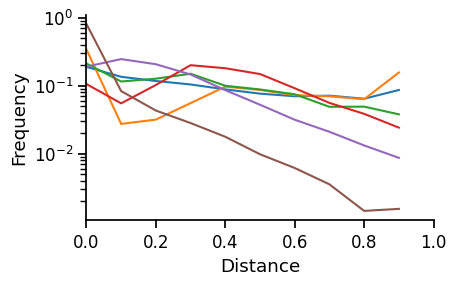

In [149]:
total_histo = []
for dataset_name in histo:
    summed_histo = np.sum(histo[dataset_name], axis=0)
    summed_histo = summed_histo / np.sum(summed_histo)

    for bin in range(10):
      freq = 0
      for b in range(10):
          freq += summed_histo[bin*10 + b]
          
      total_histo.append({'dataset' : dataset_name, 'bin' : bin/10, 'value' : freq})

total_histo = pd.DataFrame(total_histo)
with sns.plotting_context("notebook", font_scale=1.1):

  g = sns.FacetGrid(total_histo, hue='dataset', 
                  hue_order=['ENZYMES', 'IMDB', 'MUTAG', 'NCI1', 'PROTEINS', 'REDDIT'], 
                    aspect=1.5, sharey=False, sharex=False)
  g.map_dataframe(sns.lineplot, x='bin', y='value')

  g.set_axis_labels('Distance', 'Frequency')

  g.axes[0,0].set_yscale('log')
  g.axes[0,0].set_xlim(0, 1)
  # g.axes[0,0].set_ylim(0, None)

  g.axes[0,0].set_

  #g.savefig('../Latex/Figures/global_error_distances.pdf', bbox_inches='tight')

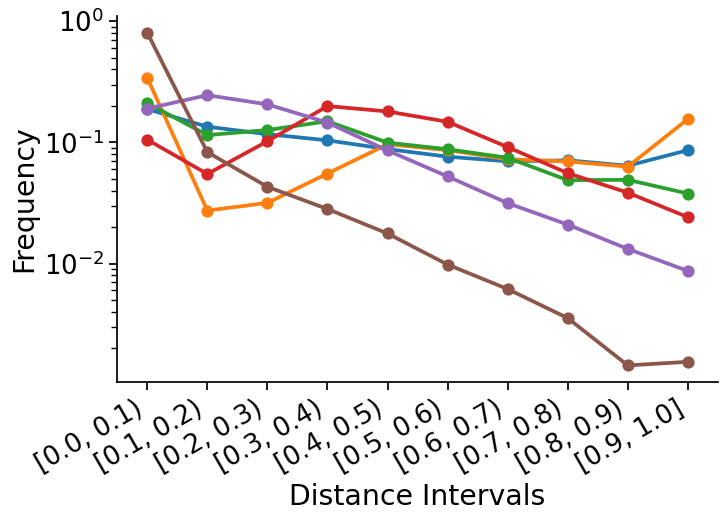

In [152]:
with sns.plotting_context("notebook", font_scale=1.7):
    g = sns.catplot(data=total_histo, x='bin', y='value', hue='dataset', kind='point', aspect=1.5, sharey=False, sharex=False, legend=False)
    g.ax.set_yscale('log')
    g.set_axis_labels('Distance Intervals', 'Frequency')

    g.ax.set_xticklabels([f'[{round(x/10,1)}, {round(x/10+0.1, 1)})' for x in range(9)] + [f'[0.9, 1.0]'])
    g.set_xticklabels(rotation=30, ha='right')
    #g.ax.set_yticklabels([f'{round(x, 2)}' for x in g.ax.get_yticks()])
    
    #g.savefig('../Latex/Figures/global_error_distances.pdf', bbox_inches='tight')

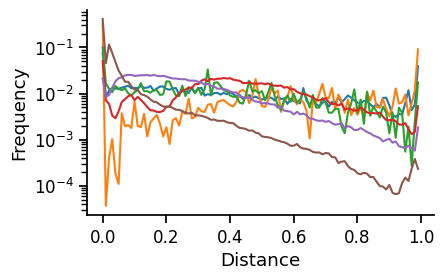

In [80]:
total_histo = []
for dataset_name in histo:
    summed_histo = np.sum(histo[dataset_name], axis=0)
    summed_histo = summed_histo / np.sum(summed_histo)

    for bin in range(100):
        total_histo.append({'dataset' : dataset_name, 'bin' : bin/100, 'value' : summed_histo[bin]})


total_histo = pd.DataFrame(total_histo)
with sns.plotting_context("notebook", font_scale=1.1):

  g = sns.FacetGrid(total_histo, hue='dataset', 
                  hue_order=['ENZYMES', 'IMDB', 'MUTAG', 'NCI1', 'PROTEINS', 'REDDIT'], 
                    aspect=1.5, sharey=False, sharex=False)
  g.map_dataframe(sns.lineplot, x='bin', y='value')

  g.set_axis_labels('Distance', 'Frequency')

  g.axes[0,0].set_yscale('log')
  # g.axes[0,0].set_xlim(0, 1)
  # g.axes[0,0].set_ylim(0, None)

  #g.savefig('../Latex/Figures/global_error_distances.pdf', bbox_inches='tight')


In [72]:
df_global_error.loc[df_global_error['dataset'] == 'IMDB', 'dataset'] = 'IMDB-BINARY'
df_global_error.loc[df_global_error['dataset'] == 'REDDIT', 'dataset'] = 'REDDIT-BINARY'

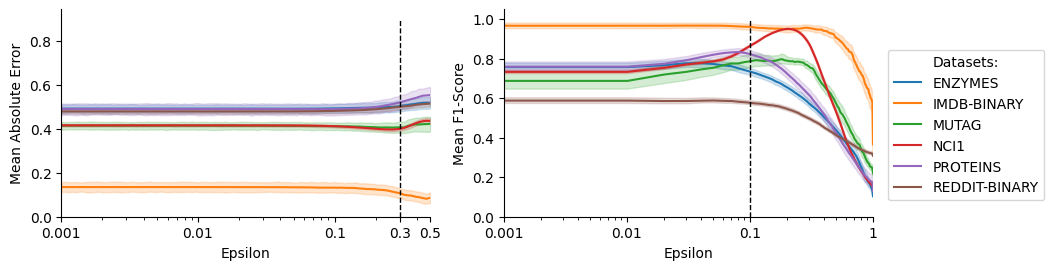

In [154]:
def custom_lineplot(data, x, y, std, **kwargs):
    if kwargs['label'] == "RANDOM":
        kwargs['color'] = 'black'

    line = sns.lineplot(data=data, x=x, y=y, **kwargs)
    #line.fill_between(data[x], data[y] - data[std], data[y] + data[std], alpha=0.1, color=kwargs['color'])
    #line.errorbar(data[x], data[y] - data[std], data[y] + data[std], alpha=0.1, color=kwargs['color'], )

g = sns.FacetGrid(df_global_error, hue='dataset', col='type',
                  hue_order=['ENZYMES', 'IMDB-BINARY', 'MUTAG', 'NCI1', 'PROTEINS', 'REDDIT-BINARY'], 
                  aspect=1.5, sharey=False, sharex=False)
g.map_dataframe(custom_lineplot, x='eps', y='value', std='std')
g.add_legend(title='Datasets:', frameon=True)
sns.move_legend(g, "center left", bbox_to_anchor=(0.85, 0.5))

g.set_titles(col_template="", row_template="")
g.set_axis_labels("Epsilon", "Mean Absolute Error")

g.axes[0,0].vlines(0.3, 0.0, df_global_error[df_global_error['type'] == 'error']['value'].max(),
                    colors='black', linestyles='dashed', alpha=1.0, linewidth=1)
g.axes[0, 1].vlines(0.1, 0.0, df_global_error[df_global_error['type'] == 'f1']['value'].max(),
                     colors='black', linestyles='dashed', alpha=1.0, linewidth=1)
g.axes[0,0].set_ylim(0.0, None)

g.axes[0,0].set_xscale('log')
g.axes[0,0].set_xlim(0.001, 0.5)
g.axes[0,0].set_xticks([0.001, 0.01, 0.1, 0.3, 0.5])
g.axes[0,0].set_xticklabels(['0.001', '0.01', '0.1', '0.3', '0.5'])

g.axes[0,1].set_xscale('log')
g.axes[0,1].set_xlim(0.001, 1)
g.axes[0,1].set_xticks([0.001, 0.01, 0.1, 1])
g.axes[0,1].set_xticklabels(['0.001', '0.01', '0.1', '1'])
g.axes[0,1].set_ylabel('Mean F1-Score')
g.axes[0,1].set_ylim(0.0, None)

plt.subplots_adjust(wspace = 0.2)

#g.savefig('../Latex/Figures/global_error.pdf', bbox_inches='tight')

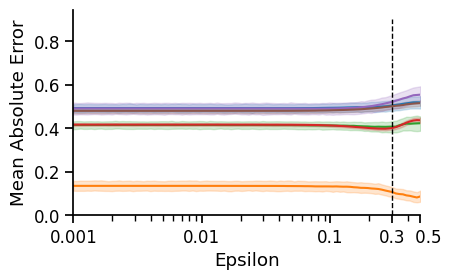

In [113]:
with sns.plotting_context("notebook", font_scale=1.1):

    def custom_lineplot(data, x, y, std, **kwargs):
        if kwargs['label'] == "RANDOM":
            kwargs['color'] = 'black'

        line = sns.lineplot(data=data, x=x, y=y, **kwargs)
        #line.fill_between(data[x], data[y] - data[std], data[y] + data[std], alpha=0.1, color=kwargs['color'])
        #line.errorbar(data[x], data[y] - data[std], data[y] + data[std], alpha=0.1, color=kwargs['color'], )

    g = sns.FacetGrid(df_global_error[df_global_error['type'] == 'error'], hue='dataset',
                    hue_order=['ENZYMES', 'IMDB-BINARY', 'MUTAG', 'NCI1', 'PROTEINS', 'REDDIT-BINARY'], 
                    aspect=1.5, sharey=False, sharex=False)
    g.map_dataframe(custom_lineplot, x='eps', y='value', std='std')

    #g.add_legend(title='Datasets:', frameon=True)
    #sns.move_legend(g, "center left", bbox_to_anchor=(0.85, 0.5))

    g.set_titles(col_template="", row_template="")
    g.set_axis_labels("Epsilon", "Mean Absolute Error")

    g.axes[0,0].vlines(0.3, 0.0, df_global_error[df_global_error['type'] == 'error']['value'].max(),
                        colors='black', linestyles='dashed', alpha=1.0, linewidth=1)
    # g.axes[0, 1].vlines(0.1, 0.0, df_global_error[df_global_error['type'] == 'f1']['value'].max(),
    #                      colors='black', linestyles='dashed', alpha=1.0, linewidth=1)

    g.axes[0,0].set_ylim(0.0, None)
    g.axes[0,0].set_xscale('log')
    g.axes[0,0].set_xlim(0.001, 0.5)
    g.axes[0,0].set_xticks([0.001, 0.01, 0.1, 0.3, 0.5])
    g.axes[0,0].set_xticklabels(['0.001', '0.01', '0.1', '0.3', '   0.5'])

    #g.savefig('../Latex/Figures/global_error_1_b.pdf', bbox_inches='tight')

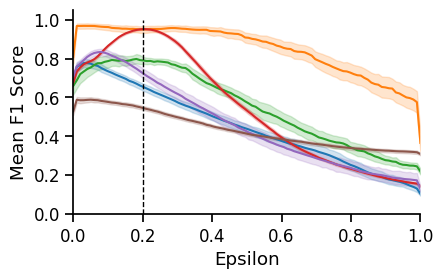

In [118]:
with sns.plotting_context("notebook", font_scale=1.1):

    def custom_lineplot(data, x, y, std, **kwargs):
        if kwargs['label'] == "RANDOM":
            kwargs['color'] = 'black'

        line = sns.lineplot(data=data, x=x, y=y, **kwargs)
        #line.fill_between(data[x], data[y] - data[std], data[y] + data[std], alpha=0.1, color=kwargs['color'])
        #line.errorbar(data[x], data[y] - data[std], data[y] + data[std], alpha=0.1, color=kwargs['color'], )

    g = sns.FacetGrid(df_global_error[df_global_error['type'] == 'f1'], hue='dataset',
                    hue_order=['ENZYMES', 'IMDB-BINARY', 'MUTAG', 'NCI1', 'PROTEINS', 'REDDIT-BINARY'], 
                    aspect=1.5, sharey=False, sharex=False)
    g.map_dataframe(custom_lineplot, x='eps', y='value', std='std')

    # g.add_legend(title='Datasets:', frameon=True)
    # sns.move_legend(g, "center left", bbox_to_anchor=(0.85, 0.5))

    g.set_titles(col_template="", row_template="")
    g.set_axis_labels("Epsilon", "Mean F1 Score")

    g.axes[0,0].vlines(0.2, 0.0, df_global_error[df_global_error['type'] == 'f1']['value'].max(),
                       colors='black', linestyles='dashed', alpha=1.0, linewidth=1)
    # g.axes[0, 1].vlines(0.1, 0.0, df_global_error[df_global_error['type'] == 'f1']['value'].max(),
    #                      colors='black', linestyles='dashed', alpha=1.0, linewidth=1)

    g.axes[0,0].set_ylim(0.0, None)
    g.axes[0,0].set_xlim(0.000, 1)

    # g.axes[0,0].set_xticks([0.001, 0.01, 0.1, 1])
    # g.axes[0,0].set_xticklabels(['0.001', '0.01', '0.1', '1'])
    #g.savefig('../Latex/Figures/global_error_2_log.pdf', bbox_inches='tight')

In [852]:
df_global_error

,eps,type,dataset,value
0,0.001,error,ENZYMES,0.493535
1,0.001,error,ENZYMES,0.419131
2,0.001,error,ENZYMES,0.623982
3,0.001,error,ENZYMES,0.486953
4,0.001,error,ENZYMES,0.615184
...,...,...,...,...
540595,1.000,f1,RANDOM,0.103035
540596,1.000,f1,RANDOM,0.201327
540597,1.000,f1,RANDOM,0.384615
540598,1.000,f1,RANDOM,0.059355


In [864]:
df_global_error.groupby(['dataset', 'type', 'eps']).agg({'value' : 'mean'}).groupby(['type','dataset']).agg({'value' : 'max'})

value
type  dataset                
error ENZYMES        0.869264
      IMDB-BINARY    0.423916
      MUTAG          0.701708
      NCI1           0.819513
      PROTEINS       0.816021
      RANDOM         0.724025
      REDDIT-BINARY  0.543883
f1    ENZYMES        0.778134
      IMDB-BINARY    0.967636
      MUTAG          0.795951
      NCI1           0.951178
      PROTEINS       0.833983
      RANDOM         0.645264
      REDDIT-BINARY  0.591586

In [818]:
import pylab

fig = pylab.figure()

figlegend = pylab.figure(figsize=(3,2))
figlegend.legend(g.axes[0,0].get_legend_handles_labels()[0],
                    g.axes[0,0].get_legend_handles_labels()[1], ncol=1, title='Datasets:')
figlegend.show()
#figlegend.savefig(f'../LaTeX/figures/global_error_legend.pdf', bbox_inches='tight')

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/575598984.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figlegend.show()


<Figure size 640x480 with 0 Axes>

<Figure size 300x200 with 0 Axes>

In [ ]:

eps_values = np.logspace(-3, 0.0, num=1000)

# Normalize X
if X.max() != 0:
    X = X / X.max()


data = []
for eps in eps_values:
    num_removed = 0
    avg_acc = []

    Y_pred = torch.ones_like(Y) * (Y.max() + 1)

    for class_label in Y.unique(sorted=False):

        # Distance matrix between nodes
        sample_indices = torch.argwhere(Y == class_label).squeeze(0)
        X_query = X[sample_indices].reshape(-1, X.shape[1])

        if len(sample_indices) > 1:

            # Calculate pairwise distance matrix
            distance = torch.cdist(X_query, X_query, p=2)

            removed_indices = []
            while True:
                num_points_outside_eps_ball = (distance > eps).count_nonzero(dim=1)

                # If all remaining points are contained in one eps-ball, we terminate
                if (num_points_outside_eps_ball == 0.0).all():
                    break
                
                # Remove the index that is the furthes away from all other points
                index = num_points_outside_eps_ball.argmax()
                distance[index, :] = 0.0
                distance[:, index] = 0.0

                removed_indices.append(index)
            
            avg_acc.append((len(sample_indices) - len(removed_indices)) / len(sample_indices))
            num_removed += len(removed_indices)

            if removed_indices != []:
                removed_indices = sample_indices[torch.tensor(removed_indices)]
                sample_indices = torch.tensor([idx for idx in sample_indices if idx not in removed_indices])
            
        Y_pred[sample_indices] = class_label

    f1 = f1_score(Y, Y_pred, average='macro')
    avg_acc = np.mean(avg_acc)

    data.append({'epsilon': eps, 'f1_score' : round(f1 * 100, 2), 'removed' : num_removed,
                 'avg_acc' : round(avg_acc * 100, 2), 'acc' : round((len(Y) - num_removed) / len(Y) * 100, 2)})

data = pd.DataFrame(data)
data


In [ ]:
from sklearn.metrics import f1_score

eps_values = [0.10, 0.05, 0.01, 0.001]

df_data = pd.DataFrame()
for eps in eps_values:
    data = []
    Y_pred = torch.ones_like(Y) * (Y.max() + 1)

    for class_label in Y.unique(sorted=False):
        # Distance matrix between nodes
        sample_indices = torch.argwhere(Y == class_label).squeeze(0)
        X_query = X[sample_indices].reshape(-1, X.shape[1])

        if len(sample_indices) > 1:

            # Calculate pairwise distance matrix
            distance = torch.cdist(X_query, X_query, p=2)

            removed_indices = []
            while True:
                num_points_outside_eps_ball = (distance > eps).count_nonzero(dim=1)

                # If all remaining points are contained in one eps-ball, we terminate
                if (num_points_outside_eps_ball == 0.0).all():
                    break
                
                # Remove the index that is the furthes away from all other points
                index = num_points_outside_eps_ball.argmax()
                distance[index, :] = 0.0
                distance[:, index] = 0.0

                removed_indices.append(index)

            for idx in range(X.shape[0]):
                if idx in sample_indices and idx not in removed_indices:
                    data.append([idx, class_label])

                elif idx not in sample_indices and \
                    ((torch.cdist(X_query, X[idx].unsqueeze(0), p=2) < eps).count_nonzero(dim=1) == 0).all():
                        
                    data.append([idx, class_label])
            
        else:
            data.append([sample_indices.item(), class_label])
        
    data = torch.tensor(data)

In [ ]:
def calculate_max_accuracy(dataset):
        # Get unique samples in x
        unique_samples, unique_indices = torch.unique(dataset[:, :-1], dim=0, return_inverse=True)

        max_correct = 0
        total_samples = 0

        for i in range(unique_samples.shape[0]):
            # Find indices of matching samples in the dataset. 
            # Necessary to use flatten() to get a 1D tensor such that 'dataset[matching_indices]' returns a 2D tensor.
            matching_indices = torch.nonzero(unique_indices == i, as_tuple=False).flatten()

            # Get matching samples and labels
            matching_samples = dataset[matching_indices]
            matching_labels = matching_samples[:, -1]

            # Count the occurrences of each class label
            _, label_counts = torch.unique(matching_labels, return_counts=True)

            # Update the maximum correct count
            max_correct += torch.max(label_counts)

            # Update the total number of samples
            total_samples += matching_samples.shape[0]

        # Calculate the maximal accuracy
        max_accuracy = max_correct / total_samples
        return max_accuracy

In [ ]:
def facet_heatmap(data, color, **kwargs):
    data = data.pivot(index="i", columns='j', values='distance')
    sns.heatmap(data, cmap='Blues', **kwargs)

index_split = [indices_graphs[:5], indices_graphs[5:]]
for i in range(2):
    data = df_dist_matrix[df_dist_matrix['idx'].isin(index_split[i])]
    g = sns.FacetGrid(data, col='type', row='normed_error', sharex='row', sharey='row', margin_titles=True)

    if i == 0:
        g.map_dataframe(facet_heatmap, cbar=False, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)
    else:
        cbar_ax = g.fig.add_axes([1.05, .3, .02, .4])  # <-- Create a colorbar axes
        g.map_dataframe(facet_heatmap, cbar_ax=cbar_ax, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)

    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    
    g.savefig(f'../Latex/Figures/heatmaps_{dataset.name}_{i}.png'.format(i), bbox_inches='tight', dpi=600)

In [ ]:
data = df_dist_matrix[df_dist_matrix['idx'] == test_index[torch.randint(0, len(test_index), (1,)).item()]]
g = sns.FacetGrid(data, col='type', row='normed_error', sharex='row', sharey='row', margin_titles=True)
g.map_dataframe(facet_heatmap, cbar=False, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
#g.savefig(f'../Latex/Figures/heatmaps_{dataset.name}_single.pdf', bbox_inches='tight')

In [ ]:
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(9, 0.5))
img = pl.imshow(a, cmap="Blues")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
#pl.savefig("../Latex/Figures/colorbar.pdf", bbox_inches='tight')

# Clustering Metric

In [ ]:
from sklearn import metrics

all_metrics = ['rand_score', 'adjusted_rand_score', 'normalized_mutual_info_score', 'adjusted_mutual_info_score',
               'homogeneity_score', 'completeness_score', 'v_measure_score', 'fowlkes_mallows_score']
def evaluate(y_pred, y_true):
    rs = metrics.rand_score(y_true, y_pred)
    ars = metrics.adjusted_rand_score(y_true, y_pred)
    nmi = metrics.normalized_mutual_info_score(y_true, y_pred)
    ami = metrics.adjusted_mutual_info_score(y_true, y_pred)
    hom = metrics.homogeneity_score(y_true, y_pred)
    com = metrics.completeness_score(y_true, y_pred)
    vms = metrics.v_measure_score(y_true, y_pred)
    fws = metrics.fowlkes_mallows_score(y_true, y_pred)


    return {'rand_score': rs, 'adjusted_rand_score': ars, 'normalized_mutual_info_score': nmi,
            'adjusted_mutual_info_score': ami, 'homogeneity_score': hom, 'completeness_score': com,
            'v_measure_score': vms, 'fowlkes_mallows_score': fws}

In [ ]:
with torch.no_grad():
    x_train = []
    y_train = []

    for idx in train_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_train.append(x_gnn)
        y_train.append(x_wl)

    x_train = torch.cat(x_train, dim=0)
    y_train = torch.cat(y_train, dim=0)

    x_test = []
    y_test = []

    for idx in test_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_test.append(x_gnn)
        y_test.append(x_wl)

    x_test = torch.cat(x_test, dim=0)
    y_test = torch.cat(y_test, dim=0)

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, Birch, BisectingKMeans
dist_data = []
num_cluster = len(torch.unique(y_test))

kmeans = KMeans(n_clusters=num_cluster, random_state=42, init='k-means++', n_init='auto').fit(x_test)
dist_data.append(evaluate(kmeans.labels_, y_test) | {'name': 'kmeans', 'num_cluster': num_cluster})

aggC_ward = AgglomerativeClustering(n_clusters=num_cluster, linkage='ward').fit(x_test)
dist_data.append(evaluate(aggC_ward.labels_, y_test) | {'name': 'aggC_ward', 'num_cluster': num_cluster})

aggC_avg = AgglomerativeClustering(n_clusters=num_cluster, linkage='average').fit(x_test)
dist_data.append(evaluate(aggC_avg.labels_, y_test) | {'name': 'aggC_avg', 'num_cluster': num_cluster})

dbscan = DBSCAN(eps=0.5, min_samples=5).fit(x_test)
dist_data.append(evaluate(dbscan.labels_, y_test) | {'name': 'dbscan', 'num_cluster': num_cluster})

optics = OPTICS(min_samples=5).fit(x_test)
dist_data.append(evaluate(optics.labels_, y_test) | {'name': 'optics', 'num_cluster': num_cluster})

birch = Birch(n_clusters=num_cluster).fit(x_test)
dist_data.append(evaluate(birch.labels_, y_test) | {'name': 'birch', 'num_cluster': num_cluster})

bisectingKmeans = BisectingKMeans(n_clusters=num_cluster).fit(x_test)
dist_data.append(evaluate(bisectingKmeans.labels_, y_test) | {'name': 'bisectingKmeans', 'num_cluster': num_cluster})

df_cluster_metrics = pd.DataFrame(dist_data)

In [ ]:
df_cluster_metrics

In [ ]:
with torch.no_grad():
    x_train = []
    y_train = []

    for idx in train_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_gnn = model.pool(x_gnn, dataset[idx].batch)
        x_wl = dataset[idx].y

        x_train.append(x_gnn)
        y_train.append(x_wl)

    x_train = torch.cat(x_train, dim=0)
    y_train = torch.cat(y_train, dim=0)

    x_test = []
    y_test = []

    for idx in test_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_gnn = model.pool(x_gnn, dataset[idx].batch)
        x_wl = dataset[idx].y

        x_test.append(x_gnn)
        y_test.append(x_wl)

    x_test = torch.cat(x_test, dim=0)
    y_test = torch.cat(y_test, dim=0)

# KNN

In [19]:
knn_runs = ['k9mmdyir', '0ni5uuq3', '9qzmqmjy']#['o84jwl99', 'r0hzi69w', 'hsoebyq6', 'h41v1r4j', '9c64l23v', 'ircwl3vt',
            #'xwp3x7vc', 'nor2tequ', 'vvw0t1se', 'tku7invn', 'abuwjdwl', 's86vy9xe' ]

df_knn = pd.DataFrame()
api = wandb.Api()
runs = api.runs("eric-bill/BachelorThesisExperiments")

for run in runs:
    if run.state == "finished" and run.id in knn_runs:

        knn = run.history(keys=['k', 'knn_accuracies', 'knn_accuracies_std'])
        knn['dataset'] = run.config['dataset']
        knn['model_type'] = get_model_type(run.config['model'])
        knn['test_accuracy'] = run.summary['test_accuracy']
        knn['run_id'] = run.id

        df_knn = pd.concat([df_knn, knn], ignore_index=True)

df_knn

,_step,k,knn_accuracies,knn_accuracies_std,dataset,model_type,test_accuracy,run_id
0,0,1,85.742690,7.896076,MUTAG,GNN,83.350876,9qzmqmjy
1,1,2,81.923977,9.387200,MUTAG,GNN,83.350876,9qzmqmjy
2,2,3,83.988304,8.453578,MUTAG,GNN,83.350876,9qzmqmjy
3,3,4,84.508772,7.569330,MUTAG,GNN,83.350876,9qzmqmjy
4,4,5,85.035088,7.356859,MUTAG,GNN,83.350876,9qzmqmjy
...,...,...,...,...,...,...,...,...
545,195,196,78.400000,2.766417,REDDIT-BINARY,1-WL+NN,78.440002,k9mmdyir
546,196,197,78.400000,2.721794,REDDIT-BINARY,1-WL+NN,78.440002,k9mmdyir
547,197,198,78.340000,2.780104,REDDIT-BINARY,1-WL+NN,78.440002,k9mmdyir
548,198,199,78.390000,2.750306,REDDIT-BINARY,1-WL+NN,78.440002,k9mmdyir


In [20]:
pivot_knn = get_acc_and_std(df_knn, group_col=['model_type','dataset'], acc_col='knn_accuracies', std_col='knn_accuracies_std', latex=True, reg=False)
pivot_knn.pivot_table(index=['model_type'], columns=['dataset'], values=['knn_accuracies'], aggfunc=lambda x: x)

knn_accuracies                            
dataset                          MUTAG               REDDIT-BINARY
model_type                                                        
1-WL+NN                            NaN  83.2 \scriptsize $\pm 2.5$
GNN         88.3 \scriptsize $\pm 6.5$  90.8 \scriptsize $\pm 1.8$

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_85441/2454141207.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])


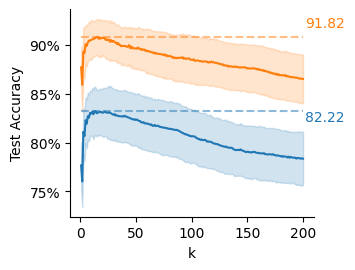

In [39]:
def plot_knn(data, x, y, std, **kwargs):
    y_max = data[y].max()
    data_max = pd.DataFrame({'max': [y_max] * len(data), x: data[x]})
    sns.lineplot(data_max, x=x, y='max', color=kwargs['color'], alpha=0.5, linestyle='--')

    line = sns.lineplot(data=data, x=x, y=y, **kwargs)

    # Fix if the text is to close togehter
    if y_max < 88.3:
        y_max -= 1
    else:
        y_max += 1
    
    line.axes.text(data[x].max() + 2, y_max, f"{round(y_max, 2)}", color=kwargs['color'])
    line.fill_between(data[x], data[y] - data[std], data[y] + data[std], alpha=0.2, color=kwargs['color'])

    # y_max = data['test_accuracy'].max()
    # data_max = pd.DataFrame({'max': [y_max] * len(data), x: data[x]})
    # sns.lineplot(data_max, x=x, y='max', color='black', alpha=0.5, linestyle='-')
    # line.axes.text(data[x].max() + 2, y_max, f"{round(y_max, 2)}")

for dataset_name in ['REDDIT-BINARY']:#df_knn.dataset.unique():
    
    g = sns.FacetGrid(df_knn[df_knn['dataset'] == dataset_name], col='dataset', hue='model_type', col_wrap=3, hue_order=['1-WL+NN', 'GNN'], margin_titles=True, sharex=False, sharey=False)
    g.map_dataframe(plot_knn, x='k', y='knn_accuracies', std='knn_accuracies_std', legend=None)
    #g.add_legend(frameon=True)
    g.set_titles(col_template="", row_template="")
    g.set_axis_labels("k", "Test Accuracy")
    g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])

    #sns.move_legend(g, "center right", bbox_to_anchor=(1.05, 0.5), title='Model Types')

    g.savefig(f'../LaTeX/Figures/knn_{dataset_name}.pdf', bbox_inches='tight')
    plt.show()

# SVM Viz

In [132]:
dataset_name = 'ENZYMES'

wlnn_name = "1-WL+NN: 86.4% Accuracy"
gnn_name = "GNN: 51.9% Accuracy"
model = torch.load(f'saved_models/GNN_{dataset_name}.pt')

In [133]:
def calc_svm_boundary_contour(X, Y, n_points=5, **kwargs):
    clf = SVC(kernel='linear', **kwargs)
    clf.fit(X, Y)

    # Create a grid of points
    x_min = np.min(X.T, axis=1)
    x_max = np.max(X.T, axis=1)
    h = (x_max - x_min) / n_points

    arr_arange = [np.arange(x_min[i], x_max[i], h[i]) for i in range(len(x_min))]
    xx = np.meshgrid(*arr_arange)
    xx = np.hstack([dim.reshape(-1, 1) for dim in np.meshgrid(*arr_arange)])

    # Calculate the decision values for the grid points
    Z = clf.predict(xx)
        
    return pd.DataFrame({'x': xx[:, 0], 'y': xx[:, 1], 'class': Z})

In [134]:
model_gnn = torch.load(f'saved_models/GNN_{dataset_name}.pt')
X_gnn = model_gnn.data_aggregate[:, :-1]
Y_gnn = model_gnn.data_aggregate[:, -1]

X_gnn = TSNE(n_components=2).fit_transform(X_gnn)

df_gnn = pd.DataFrame(X_gnn, columns=['x', 'y'])
df_gnn['class'] = Y_gnn
df_gnn['model_type'] = gnn_name
df_gnn['scatter'] = 1

df_svm = calc_svm_boundary_contour(X_gnn, Y_gnn, n_points=100)
df_svm['model_type'] = gnn_name
df_svm['scatter'] = 0

df_gnn = pd.concat([df_gnn, df_svm])

model_wlnn = torch.load(f'saved_models/WLNN_{dataset_name}.pt')
X_wlnn = model_wlnn.data_aggregate[:, :-1]
Y_wlnn = model_wlnn.data_aggregate[:, -1]

X_wlnn = TSNE(n_components=2).fit_transform(X_wlnn)

df_wlnn = pd.DataFrame(X_wlnn, columns=['x', 'y'])
df_wlnn['class'] = Y_wlnn
df_wlnn['model_type'] = wlnn_name
df_wlnn['scatter'] = 1

df_svm = calc_svm_boundary_contour(X_wlnn, Y_wlnn, n_points=100)
df_svm['model_type'] = wlnn_name
df_svm['scatter'] = 0

df_wlnn = pd.concat([df_wlnn, df_svm])

df_svm = pd.concat([df_gnn, df_wlnn])

(-33.081974029541016, 36.1970100402832)

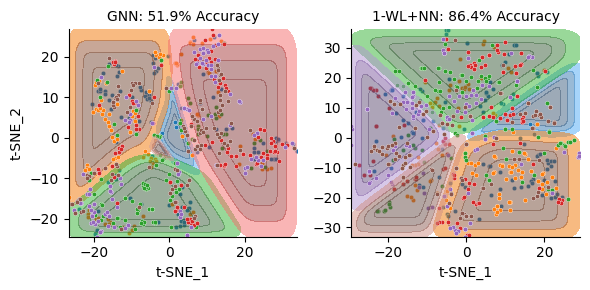

In [135]:
def custom_plotter(data, x, y, **kwargs):
    sns.kdeplot(data=data[data['scatter'] == 0], x=x, y=y, levels=5, alpha=0.5, fill=True, thresh=0.1, **kwargs)
    sns.scatterplot(data=data[data['scatter'] == 1], x=x, y=y, s=10, **kwargs)

g = sns.FacetGrid(df_svm, col='model_type', hue='class', margin_titles=True, sharex=False, sharey=False)
g.map_dataframe(custom_plotter, x='x', y='y')

g.set_titles(col_template="{col_name}", row_template="{row_name}")
#g.add_legend(title='Class Label', frameon=True, ncol=2)
g.set_axis_labels(f't-SNE_1', f't-SNE_2')

x_min_gnn, y_min_gnn = df_svm[df_svm['model_type'] == gnn_name][['x', 'y']].min()
x_max_gnn, y_max_gnn = df_svm[df_svm['model_type'] == gnn_name][['x', 'y']].max()

g.axes[0, 0].set_xlim(x_min_gnn, x_max_gnn)
g.axes[0, 0].set_ylim(y_min_gnn, y_max_gnn)

x_min_wlnn, y_min_wlnn = df_svm[df_svm['model_type'] == wlnn_name][['x', 'y']].min()
x_max_wlnn, y_max_wlnn = df_svm[df_svm['model_type'] == wlnn_name][['x', 'y']].max()
g.axes[0, 1].set_xlim(x_min_wlnn, x_max_wlnn)
g.axes[0, 1].set_ylim(y_min_wlnn, y_max_wlnn)

#g.savefig(f'../LaTeX/figures/tsne_svm_lin_{dataset_name}.pdf', bbox_inches='tight')

In [137]:
import pylab

fig = pylab.figure()

figlegend = pylab.figure(figsize=(3,2))
figlegend.legend(g.axes[0,0].get_legend_handles_labels()[0],
                    g.axes[0,0].get_legend_handles_labels()[1], ncol=6, title='Datasets:')
figlegend.show()
figlegend.savefig(f'../LaTeX/figures/svm_lin_legend.pdf', bbox_inches='tight')

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_2657/3449159424.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figlegend.show()


<Figure size 640x480 with 0 Axes>

<Figure size 300x200 with 0 Axes>

# Quantil

In [ ]:
def calc_quantil_performance(dataframe, grouping_columns, quantils):
    rows = []

    for (grouping_values, grouped_dataframe) in dataframe.groupby(grouping_columns):
        for q in quantils:
            index = grouped_dataframe.index[grouped_dataframe['test_accuracy'] >= grouped_dataframe['test_accuracy'].quantile(1 - q, interpolation='lower')]
            grouping_info = {column: value for column, value in zip(grouping_columns, grouping_values)}
            
            for i in index:
                rows.append({'Quantile' : f'{int(q*100)}%', 'train_accuracy' : dataframe.loc[i]['train_accuracy'],
                             'val_accuracy' : dataframe.loc[i]['val_accuracy'], 'test_accuracy' : dataframe.loc[i]['test_accuracy'],
                            } | grouping_info)

    return pd.DataFrame(rows)

In [ ]:
df_qunatil = calc_quantil_performance(runs_df, ['dataset', 'model_type'], quantils=[0.01, 0.05, 0.10, 0.25, 0.5, 1.0])
df_qunatil['difference'] = df_qunatil['train_accuracy'] - df_qunatil['test_accuracy']

In [ ]:
with sns.plotting_context("notebook", font_scale=1.3):
    for dataset_name in df_qunatil['dataset'].unique():
        df = df_qunatil[df_qunatil['dataset'] == dataset_name]

        ax = sns.barplot(df, x='Quantile', y='difference', hue='model_type', hue_order=['1-WL+NN', 'GNN'], estimator='mean', errorbar='se', saturation=1.0)
        sns.despine(bottom = False, left = False)

        #bar.set_title('Absolute Difference in Classification Accuracies between Training and Testing')
        ax.set_ylabel('Train Acc. - Test Acc.')

        y_max = df[['difference', 'Quantile', 'model_type']].groupby(['Quantile', 'model_type']).mean().max().abs().item()
        y_min = df[['difference', 'Quantile', 'model_type']].groupby(['Quantile', 'model_type']).mean().min().item()

        if y_min > 0:
            y_min = - 0.2 * y_max

        ax.set_ylim([1.1* y_min, 1.1 * y_max])

        if dataset_name == 'MUTAG' or dataset_name == 'REDDIT-BINARY':
            ax.set_yticks([int(y_min)] + ax.get_yticks()[1:])

        ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])

        ax.axhline(0.0, color='black', linestyle='--', alpha=0.5, snap=True)
        ax.legend_.remove()

        fig = ax.get_figure()
        #fig.savefig(f'../LaTeX/figures/train_test_diff_{dataset_name}.pdf', bbox_inches='tight')

        plt.show()

In [ ]:
import pylab

fig = pylab.figure()

figlegend = pylab.figure(figsize=(3,2))
figlegend.legend(ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1], ncol=2)
figlegend.show()
#figlegend.savefig(f'../LaTeX/figures/train_test_diff_legend.pdf', bbox_inches='tight')


In [ ]:
df_qunatil = calc_quantil_performance(runs_df[(runs_df['model_type'] == '1-WL+NN') & (runs_df['k_wl'] > 0)], ['dataset', 'k_wl'], quantils=[0.01, 0.05, 0.10, 0.25, 0.5, 1.0])
df_qunatil['difference'] = df_qunatil['train_accuracy'] - df_qunatil['test_accuracy']

In [ ]:
with sns.plotting_context("notebook", font_scale=1.3):
    for dataset_name in df_qunatil['dataset'].unique():
        df = df_qunatil[df_qunatil['dataset'] == dataset_name]

        ax = sns.barplot(df, x='Quantile', y='difference', hue='k_wl', hue_order=[1, 2, 3, 4], estimator='mean', errorbar='se', saturation=1.0)
        sns.despine(bottom = False, left = False)

        #bar.set_title('Absolute Difference in Classification Accuracies between Training and Testing')
        ax.set_ylabel('Train Acc. - Test Acc.')

        y_max = df[['difference', 'Quantile', 'k_wl']].groupby(['Quantile', 'k_wl']).mean().max().abs().item()
        y_min = df[['difference', 'Quantile', 'k_wl']].groupby(['Quantile', 'k_wl']).mean().min().item()

        y_min = - 0.2 * y_max
        ax.set_ylim([1.1* y_min, 1.1 * y_max])

        if dataset_name == 'IMDB-BINARY':
            ax.set_yticks([int(y_min)] + ax.get_yticks()[1:])

        ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])

        ax.axhline(0.0, color='black', linestyle='--', alpha=0.5, snap=True)
        ax.legend_.remove()

        fig = ax.get_figure()
        #fig.savefig(f'../LaTeX/figures/train_test_diff_k_wl_{dataset_name}.pdf', bbox_inches='tight')

        print(f'Dataset: {dataset_name}')
        plt.show()

        

In [ ]:
import pylab

fig = pylab.figure()

figlegend = pylab.figure(figsize=(3,2))
figlegend.legend(ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1], ncol=4, title='1-WL Iterations:')
figlegend.show()
figlegend.savefig(f'../LaTeX/figures/train_test_diff_k_wl_legend.pdf', bbox_inches='tight')

# Unbalanceness

In [ ]:
dataset = torch_geometric.datasets.TUDataset(root=f"datasets", name="PROTEINS").shuffle()
dataset.y.unique(sorted=False, return_counts=True)

In [ ]:
dataset_list = ["ENZYMES", "PROTEINS", "IMDB-BINARY", "IMDB-MULTI", "NCI1", "MUTAG", "REDDIT-BINARY", "REDDIT-MULTI-5K"]

data = []
for dataset_name in dataset_list:
    dataset = torch_geometric.datasets.TUDataset(root=f"datasets", name=dataset_name).shuffle()
    unbalance = utils.calc_shannon_diversity(dataset)
    data.append([dataset_name, unbalance])

clear_output()
df_unbalances = pd.DataFrame(data, columns=["dataset", "shannon_diversity"])
df_unbalances.pivot_table(columns="dataset", values="shannon_diversity")

In [ ]:
api = wandb.Api(timeout=30)

# Project is specified by <entity/project-name>
runs = api.runs("eric-bill/BachelorThesisExperiments")

dist_data = []
for run in runs:
    if run.state == "finished" and ': Theoretical Accuracy' in run.name:
        history = run.history()
        history.sort_values(by='k_wl', ascending=True, inplace=True)

        row = f'& {run.config["dataset"]} '
        last_acc = 0.0
        for acc in history['max_acc']:
            if acc > last_acc:
                row += f'& {acc:.2f} '
            else:
                row += f'& - '
            last_acc = acc
        row += '\\\\'
        print(row)

# Number of 1-WL Iterations Dependency

Dataset: REDDIT-BINARY


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/1101166230.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])


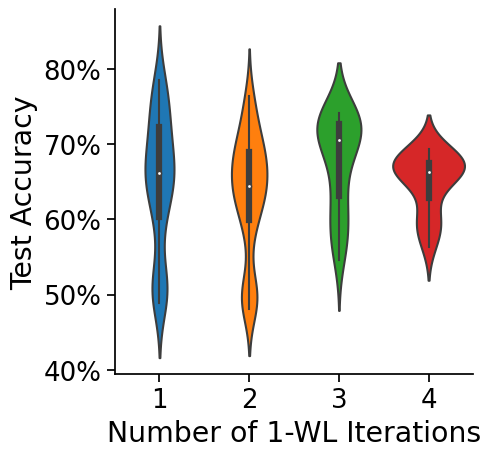

Dataset: ENZYMES


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/1101166230.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])


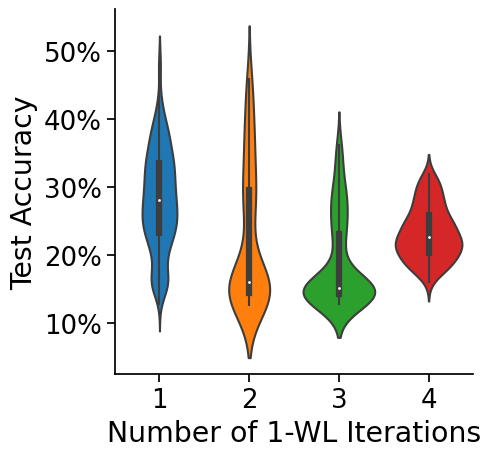

Dataset: MUTAG


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/1101166230.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])


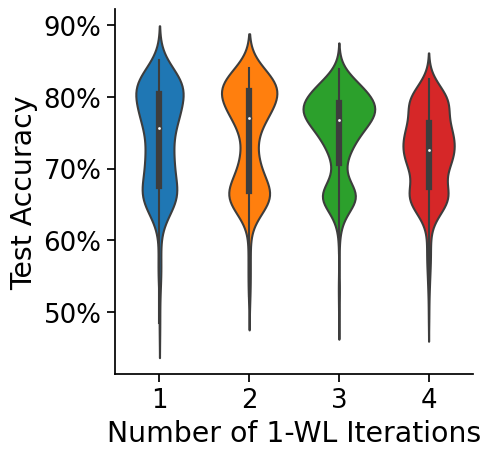

Dataset: NCI1


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/1101166230.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])


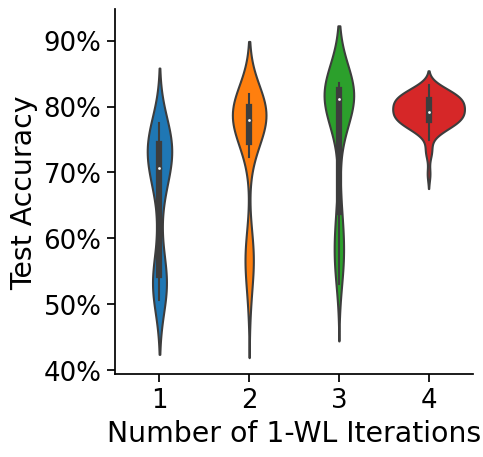

Dataset: PROTEINS


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/1101166230.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])


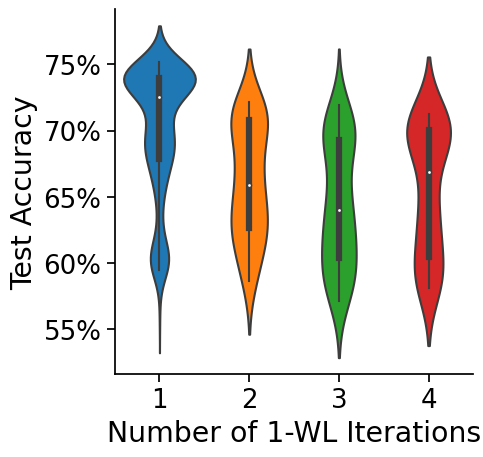

Dataset: IMDB-BINARY


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/1101166230.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])


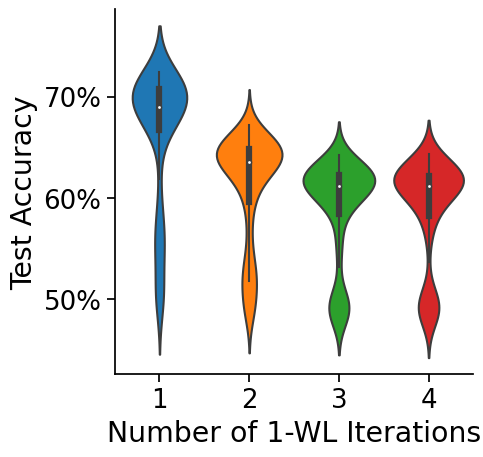

In [844]:
k_wl_df = runs_df[runs_df['model_type'] == '1-WL+NN'][['k_wl', 'dataset', 'test_accuracy']].reset_index()
k_wl_df['k_wl'] = k_wl_df['k_wl'].astype(int)
k_wl_df = k_wl_df[k_wl_df['k_wl'] > -1]
k_wl_df.dropna(inplace=True)

with sns.plotting_context("notebook", font_scale=1.7):

    for ds in k_wl_df['dataset'].unique():
        print(f'Dataset: {ds}')

        g = sns.catplot(data=k_wl_df[k_wl_df['dataset'] == ds], y='test_accuracy', x='k_wl', kind='violin', alpha=1.0, saturation=1.0)
        g.set_titles('{col_name}')
        g.set_ylabels('Test Accuracy')
        g.set_xlabels('Number of 1-WL Iterations')
        g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])
        plt.show()

        g.savefig(f'../LaTeX/figures/k_wl_violin_{ds}.pdf', bbox_inches='tight')

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/995759597.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}' for y in g.axes[0, 0].get_yticks()])


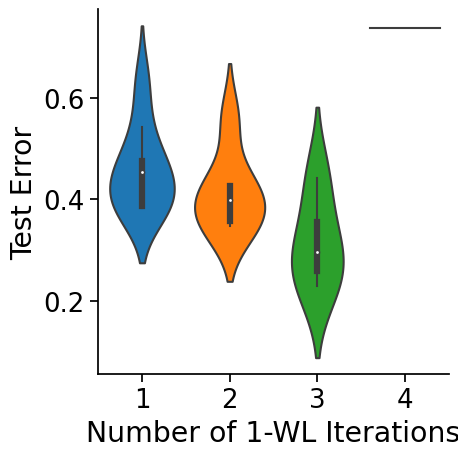

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/995759597.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}' for y in g.axes[0, 0].get_yticks()])


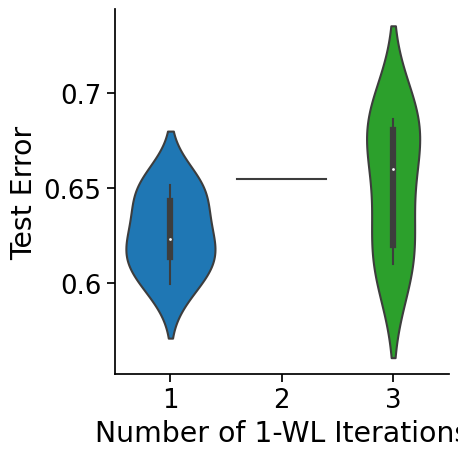

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/995759597.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}' for y in g.axes[0, 0].get_yticks()])


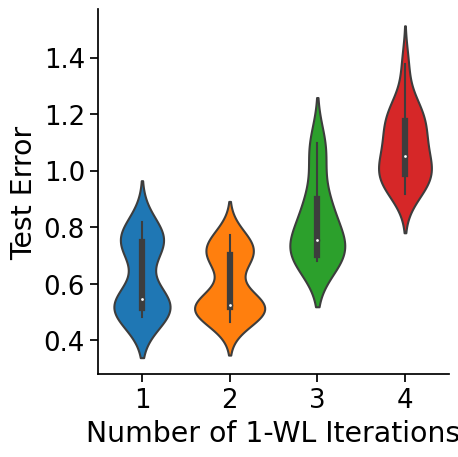

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/995759597.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}' for y in g.axes[0, 0].get_yticks()])


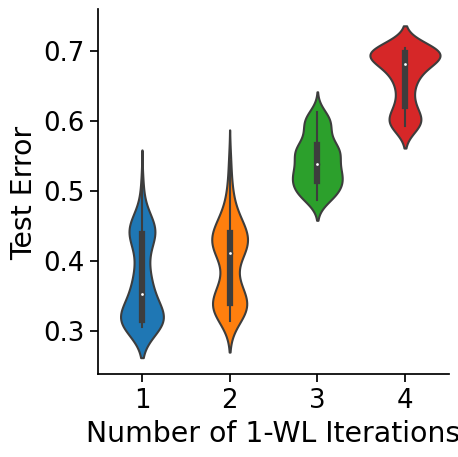

In [845]:
k_wl_df = runs_df[runs_df['model_type'] == '1-WL+NN'][['k_wl', 'dataset', 'test_error']].reset_index()
k_wl_df['k_wl'] = k_wl_df['k_wl'].astype(int)
k_wl_df.dropna(inplace=True)

with sns.plotting_context("notebook", font_scale=1.7):

    for ds in k_wl_df['dataset'].unique():
        g = sns.catplot(data=k_wl_df[k_wl_df['dataset'] == ds], y='test_error', x='k_wl', kind='violin', alpha=1.0, saturation=1.0)
        g.set_titles('{col_name}')
        g.set_ylabels('Test Error')
        g.set_xlabels('Number of 1-WL Iterations')
        g.axes[0, 0].set_yticklabels([f'{round(y, 2)}' for y in g.axes[0, 0].get_yticks()])
        plt.show()

        g.savefig(f'../LaTeX/figures/k_wl_violin_{ds}.pdf', bbox_inches='tight')

# Unique Colors

In [55]:
dataset = TUDataset(root=f"datasets/", name="ZINC_full")

Extracting datasets/ZINC_full/ZINC_full.zip
Processing...
Done!


In [ ]:
dataset.len()

In [65]:
from torch_geometric.datasets import TUDataset
from utils import Wrapper_WL_TUDataset
from utils import Constant_Long
import os.path as osp

dataset_name = ['alchemy_full', 'alchemy_10k']
dataset_name.sort()

data = []

for ds in dataset_name:
    print(f'Dataset: {ds}')

    if ds == 'ZINC_10k':
        path = osp.join(osp.dirname(osp.realpath('/Users/ericbill/LOCAL/Bachelor Arbeit LaTex/Code/gnn_alchemy_10K.py')), '.', 'datasets', "ZINC_10k")

        infile = open("train_zinc_10.index", "r")
        for line in infile:
            indices_train = line.split(",")
            indices_train = [int(i) for i in indices_train]

        infile = open("val_zinc_10.index", "r")
        for line in infile:
            indices_val = line.split(",")
            indices_val = [int(i) for i in indices_val]

        infile = open("test_zinc_10.index", "r")
        for line in infile:
            indices_test = line.split(",")
            indices_test = [int(i) for i in indices_test]

        indices = indices_train
        indices.extend(indices_val)
        indices.extend(indices_test)

        dataset = TUDataset(path, name="ZINC_full")[indices]

    elif ds == 'alchemy_10k':
        path = osp.join(osp.dirname(osp.realpath('/Users/ericbill/LOCAL/Bachelor Arbeit LaTex/Code/gnn_alchemy_10K.py')), '.', 'datasets', "alchemy_10K")

        infile = open("train_al_10.index", "r")
        for line in infile:
            indices_train = line.split(",")
            indices_train = [int(i) for i in indices_train]

        infile = open("val_al_10.index", "r")
        for line in infile:
            indices_val = line.split(",")
            indices_val = [int(i) for i in indices_val]

        infile = open("test_al_10.index", "r")
        for line in infile:
            indices_test = line.split(",")
            indices_test = [int(i) for i in indices_test]

        indices = indices_train
        indices.extend(indices_val)
        indices.extend(indices_test)

        dataset = TUDataset(path, name="alchemy_full")[indices]

    else:
        dataset = TUDataset(root=f"datasets", name=ds)
    
    if dataset._data.x is None:
        dataset.transform = Constant_Long(0)

    for k in range(11):
            wl_dataset = Wrapper_WL_TUDataset(dataset, k_wl=k, wl_convergence=False)
            unique = wl_dataset.x.unique(sorted=False).shape[0]
            total = wl_dataset.x.shape[0]

            print(f'k: {k}, unique: {unique}, total: {total}')
            data.append({'dataset' :  ds, 'unique' : unique, 'total' : total, 'ratio' : unique / total, 'k_wl' : k})

df_colors = pd.DataFrame(data)

Dataset: alchemy_10k
k: 0, unique: 2, total: 121422
k: 1, unique: 70, total: 121422
k: 2, unique: 2764, total: 121422
k: 3, unique: 33903, total: 121422
k: 4, unique: 76822, total: 121422
k: 5, unique: 98394, total: 121422
k: 6, unique: 104687, total: 121422
k: 7, unique: 105907, total: 121422
k: 8, unique: 106109, total: 121422
k: 9, unique: 106149, total: 121422
k: 10, unique: 106166, total: 121422
Dataset: alchemy_full


Extracting datasets/alchemy_full/alchemy_full.zip
Processing...
Done!


k: 0, unique: 2, total: 2046329
k: 1, unique: 70, total: 2046329
k: 2, unique: 4782, total: 2046329
k: 3, unique: 164224, total: 2046329
k: 4, unique: 620332, total: 2046329
k: 5, unique: 995264, total: 2046329
k: 6, unique: 1166951, total: 2046329
k: 7, unique: 1216094, total: 2046329
k: 8, unique: 1225861, total: 2046329
k: 9, unique: 1227632, total: 2046329
k: 10, unique: 1227904, total: 2046329


In [69]:
print(df_colors.pivot_table(index=['dataset'], columns=['k_wl'], values=['total'], aggfunc=lambda x: x).to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & \multicolumn{11}{r}{total} \\
k_wl & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\
dataset &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
alchemy_10k & 121422 & 121422 & 121422 & 121422 & 121422 & 121422 & 121422 & 121422 & 121422 & 121422 & 121422 \\
alchemy_full & 2046329 & 2046329 & 2046329 & 2046329 & 2046329 & 2046329 & 2046329 & 2046329 & 2046329 & 2046329 & 2046329 \\
\bottomrule
\end{tabular}



In [ ]:
from torch_geometric.datasets import TUDataset
from utils import Wrapper_WL_TUDataset
from utils import Constant_Long

dataset_name = ['ENZYMES', 'PROTEINS', 'IMDB-BINARY','NCI1', 'MUTAG', 'REDDIT-BINARY']
dataset_name.sort()

data = []

for ds in dataset_name:
    dataset = TUDataset(root=f"datasets", name=ds)

    if dataset._data.x is None:
        dataset.transform = Constant_Long(0)

    for k in range(11):
        wl_dataset = Wrapper_WL_TUDataset(dataset, k_wl=k, wl_convergence=False)
        unique = wl_dataset.x.unique(sorted=False).shape[0]
        total = wl_dataset.x.shape[0]

        data.append({'dataset' :  ds, 'unique' : unique, 'total' : total, 'ratio' : unique / total, 'k_wl' : k})

df_colors = pd.DataFrame(data)

In [ ]:
sns.reset_defaults()
# sns.set(font_scale=1.0)
# sns.set_style(style='white')
# sns.set_style(rc={'axes.saturation' : 1.0, 'text.usetex' : True})

g = sns.FacetGrid(data=df_colors, hue='dataset', legend_out=True, aspect=1.5)
g.map(sns.lineplot, 'k_wl', 'ratio')
g.map(sns.scatterplot, 'k_wl', 'ratio')

g.add_legend(title='Datasets:', frameon=True)
sns.move_legend(g, "center left", bbox_to_anchor=(1.175, 0.5))

g.map(sns.scatterplot, x=[0], y=[-0.05], alpha=0.0)

g.set_ylabels('Ratio of Unique Colors')
g.set_xlabels('Number of 1-WL Iterations')

g.set(xticks=np.arange(0,11,1), yticks=np.arange(0,1.1,0.2))

axins = g.axes[0, 0].inset_axes([1.2, 0.5, 0.47, 0.47])
sns.lineplot(data=df_colors, x='k_wl', y='ratio', hue='dataset', ax=axins)
sns.scatterplot(data=df_colors, x='k_wl', y='ratio', hue='dataset'
                , ax=axins)

axins.legend_.remove()

axins.set_xlim(0.5, 3.5)
axins.set_ylim(-0.05, 0.4)
axins.set_yticks(np.arange(0,0.41,0.1))

g.axes[0, 0].indicate_inset_zoom(axins, edgecolor="black", alpha=0.3)

#g.savefig(f'../LaTeX/figures/wl_unique_colors.pdf', bbox_inches='tight')

In [ ]:
df_colors.pivot_table(index='dataset', columns='k_wl', values='unique').to_latex(f'wl_unique_colors.tex', float_format="%.2f")

In [ ]:
df_colors.pivot_table(index='dataset', values='total')

In [ ]:
model = torch.load(f'saved_models/WLNN_{dataset_name}.pt')

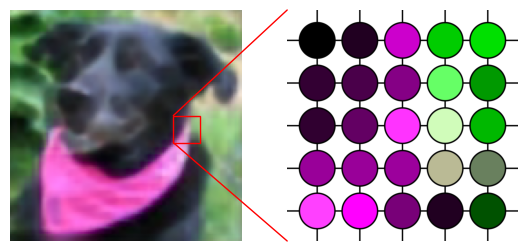

In [126]:
import matplotlib.image as mpimg
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar



img_dog = mpimg.imread('/Users/ericbill/Downloads/img1438.png')
img_graph  = mpimg.imread('/Users/ericbill/Downloads/BachelorThesis-3-2-3.png')


fig, ax = plt.subplots(ncols=1, figsize=[6, 3])

ax.imshow(img_dog)
ax.set_axis_off()

axins2 = ax.inset_axes([1.2, 0.0, 0.97, 1.0])
axins2.set_xticks([])
axins2.set_yticks([])
axins2.set_xticklabels([])
axins2.set_yticklabels([])

axins2.set_xlim(90, 105)
axins2.set_ylim(58, 73)
#axins2.imshow(img_dog)
ax.indicate_inset_zoom(axins2, edgecolor="red", alpha=1.0)
axins2.axis('off')

axins = ax.inset_axes([1.2, 0.0, 1.0, 1.0])
axins.imshow(img_graph)
axins.axis('off')

fig.savefig(f'../LaTeX/figures/encoding_example.pdf', bbox_inches='tight')

In [87]:
ax.get_xlim(), ax.get_ylim()

((-0.5, 127.5), (127.5, -0.5))